## Vanilla Gan Tutorial!

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

generator에서 `tanh`를 activation으로 활용합니다.

`tanh`를 활용하면 output이 -1 ~ 1 사이로 나오기 때문에 **Normalize**를 해줄 때 127.5로 나눈 뒤 1을 빼줍니다.

In [4]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

**min** 값과 **max** 값이 -1 ~ 1사이의 범위를 가져야 합니다.

In [5]:
x_train.min(), x_train.max()

(-1.0, 1.0)

`x_train` 값은 현재 28 * 28로 되어 있습니다. 이를 Flatten하게 펴줍니다.

In [6]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

필요한 모듈을 import 합니다.

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

## Hyperparameters

`NOISE_DIM`을 정의 합니다.

NOISE_DIM은 자유롭게 설정할 수 있으며, generator의 **input**으로 들어갑니다.

In [8]:
# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
adam = Adam(lr=0.0002, beta_1=0.5)

## Generator

generator를 정의합니다.

In [9]:
generator = Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

## Discriminator

discriminator를 정의합니다.

In [11]:
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

반드시 dicriminator를 **compile** 해주어야 합니다.

In [13]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

## Gan

generator와 discriminator를 연결합니다.

In [14]:
# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 합니다.
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

gan 모델을 정의합니다.

In [15]:
gan = Model(gan_input, output)

In [16]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1463312   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


## Compile

In [17]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

## Batch

이미지 batch를 생성합니다. MNIST 이미지 batch가 차례대로 생성됩니다.

In [18]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

##  시각화를 위한 유틸 함수 정의

In [19]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## 학습

In [20]:
BATCH_SIZE = 128
EPOCHS= 50

In [21]:
loss_function = tf.keras.losses.BinaryCrossentropy()

In [22]:
optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [23]:
train_loss = tf.keras.metrics.BinaryCrossentropy(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

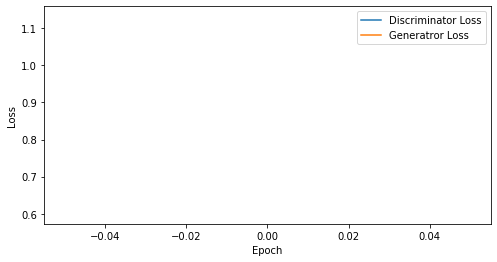

epoch: 1, Discriminator Loss: 0.5994292497634888, Generator Loss: 1.1322251558303833


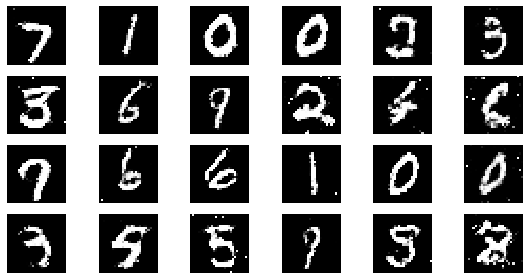

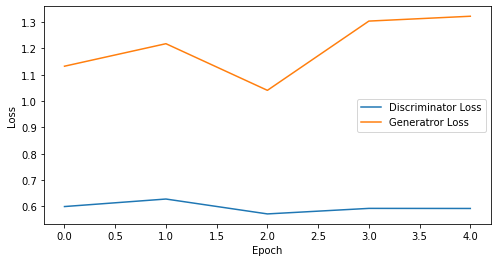

epoch: 5, Discriminator Loss: 0.596705973148346, Generator Loss: 1.2031847953796386


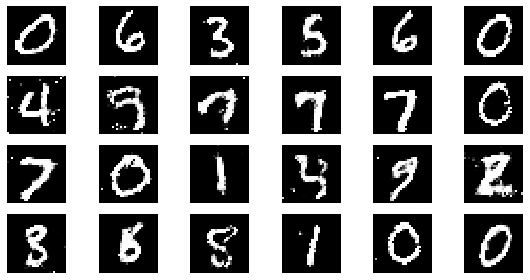

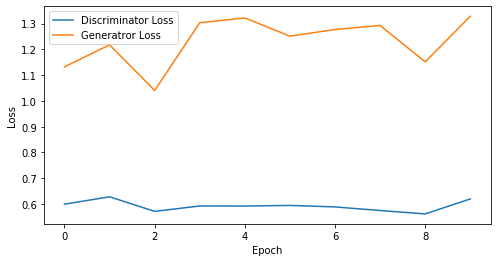

epoch: 10, Discriminator Loss: 0.5923080146312714, Generator Loss: 1.231764554977417


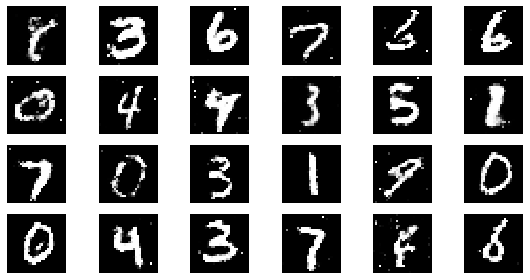

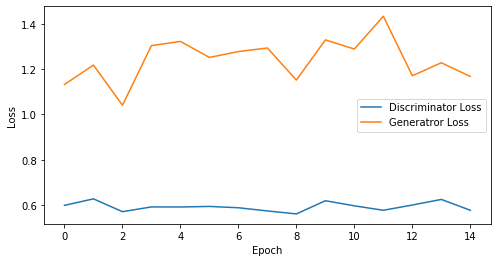

epoch: 15, Discriminator Loss: 0.593469242254893, Generator Loss: 1.2403248151143391


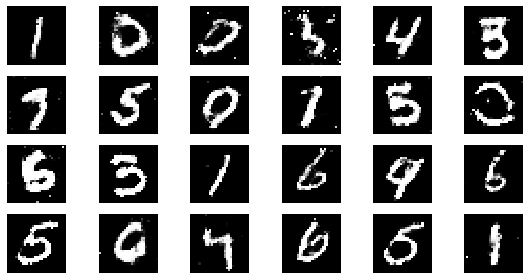

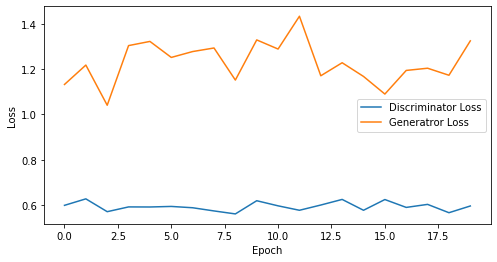

epoch: 20, Discriminator Loss: 0.5942246615886688, Generator Loss: 1.2294869124889374


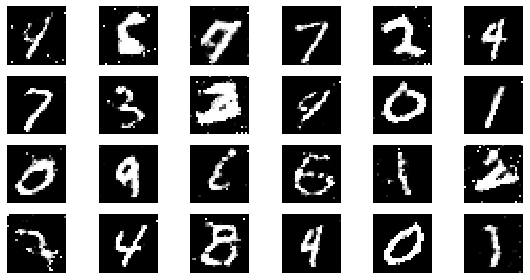

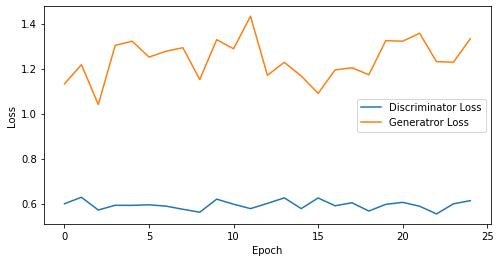

epoch: 25, Discriminator Loss: 0.5937843990325927, Generator Loss: 1.2424570941925048


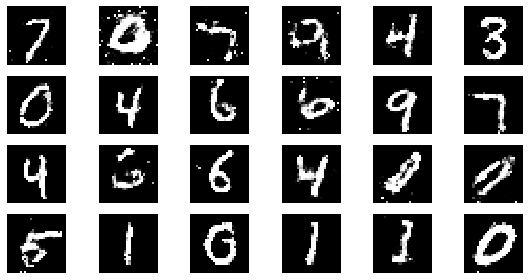

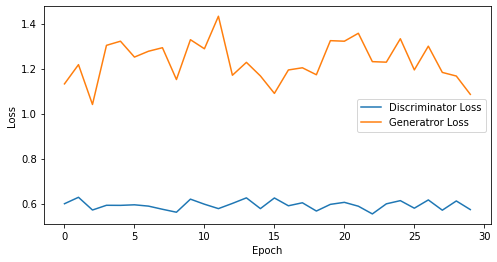

epoch: 30, Discriminator Loss: 0.5932048420111339, Generator Loss: 1.2330509106318155


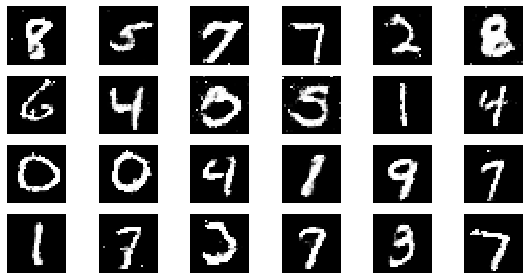

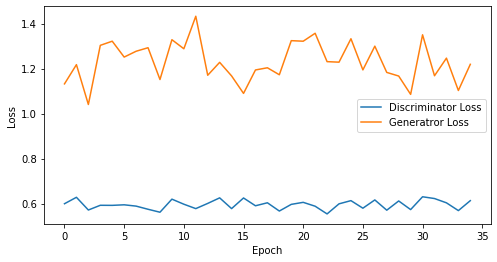

epoch: 35, Discriminator Loss: 0.5952658534049988, Generator Loss: 1.2308267593383788


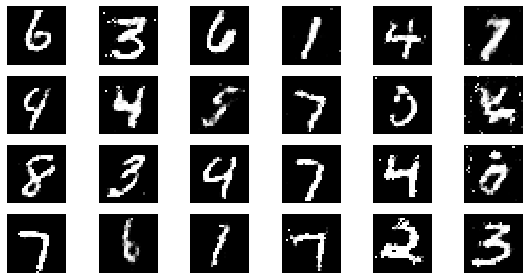

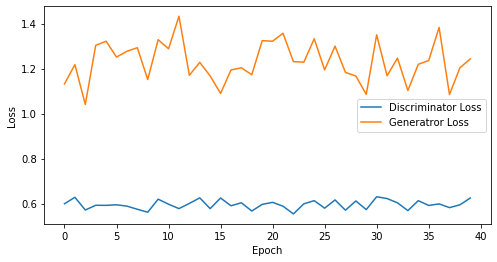

epoch: 40, Discriminator Loss: 0.5956525504589081, Generator Loss: 1.230743545293808


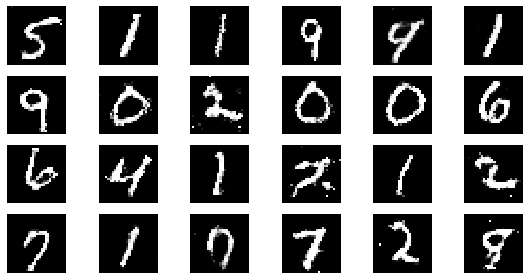

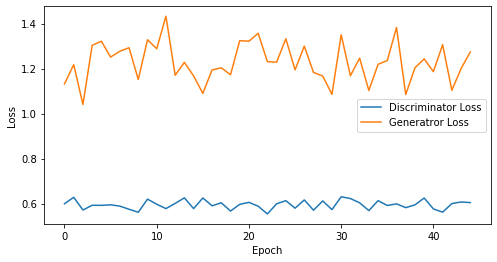

epoch: 45, Discriminator Loss: 0.5950222147835625, Generator Loss: 1.22891116672092


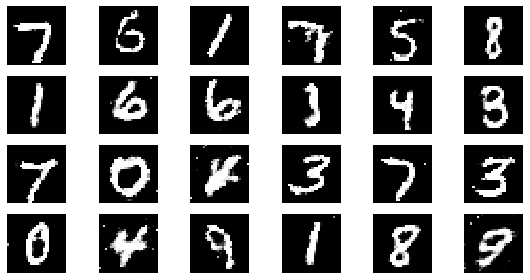

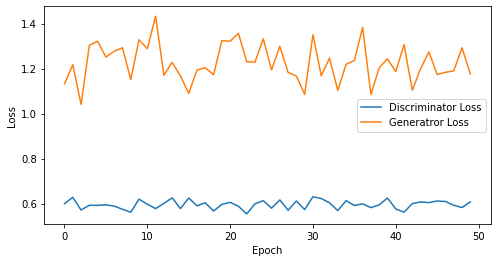

epoch: 50, Discriminator Loss: 0.595591914653778, Generator Loss: 1.2263532972335816


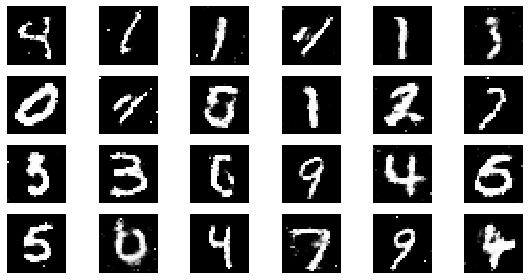

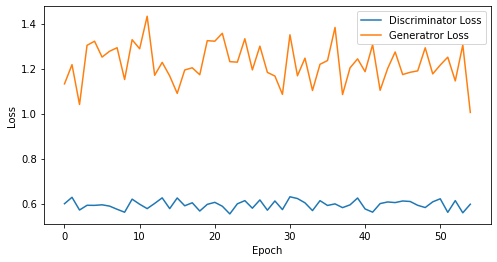

epoch: 55, Discriminator Loss: 0.5951204711740667, Generator Loss: 1.2225543303923174


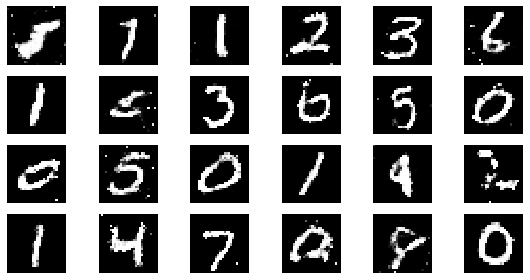

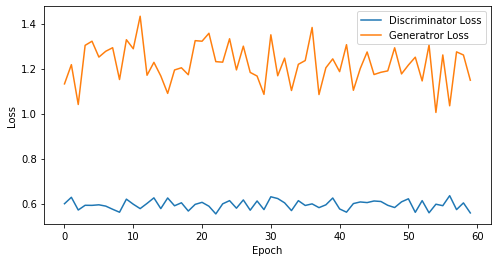

epoch: 60, Discriminator Loss: 0.5948738396167755, Generator Loss: 1.2203315754731496


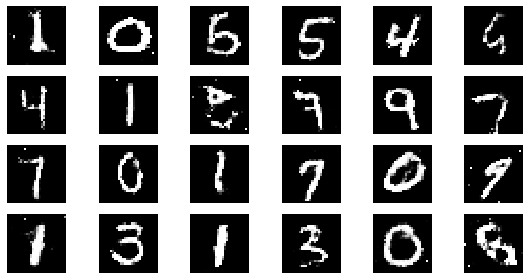

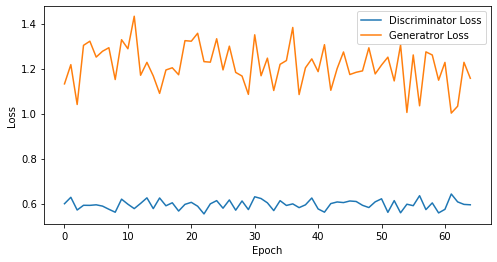

epoch: 65, Discriminator Loss: 0.5955134492654067, Generator Loss: 1.2133508975689227


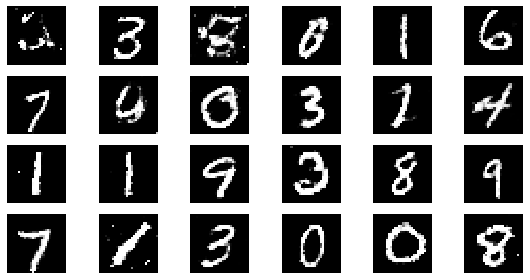

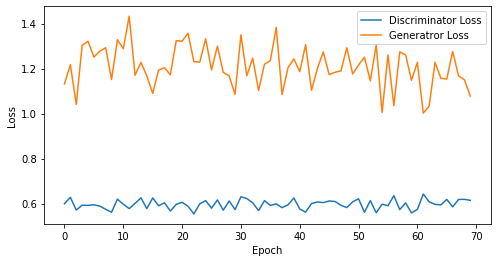

epoch: 70, Discriminator Loss: 0.5966339937278202, Generator Loss: 1.2099131516047887


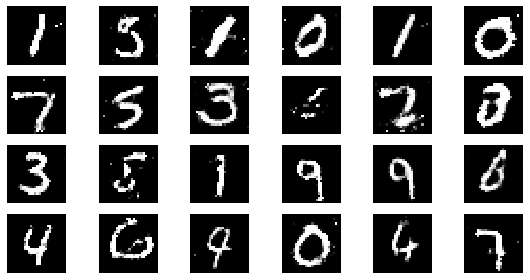

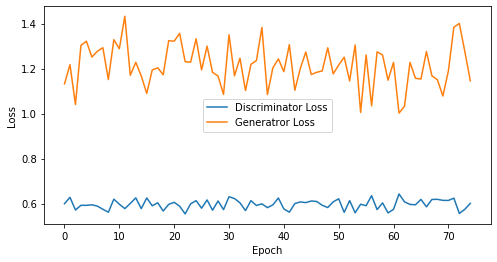

epoch: 75, Discriminator Loss: 0.5964618261655171, Generator Loss: 1.2145421997706096


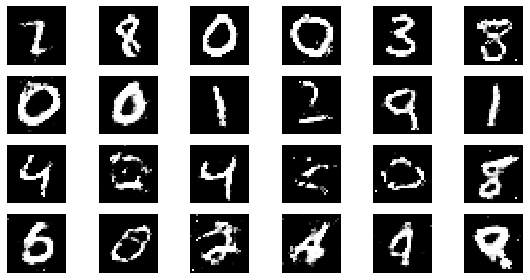

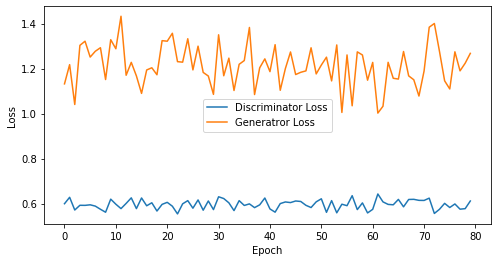

epoch: 80, Discriminator Loss: 0.5959978416562081, Generator Loss: 1.2144650369882584


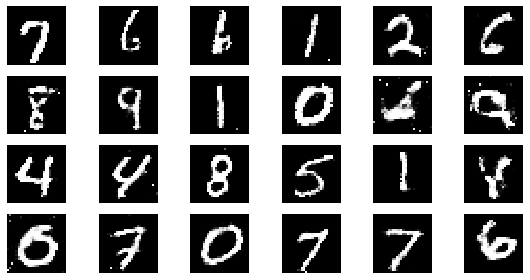

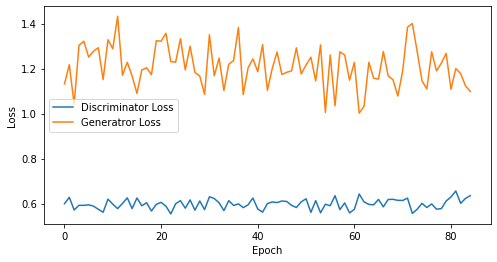

epoch: 85, Discriminator Loss: 0.5979385621407453, Generator Loss: 1.210183084712309


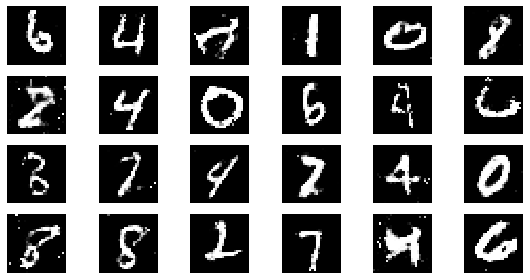

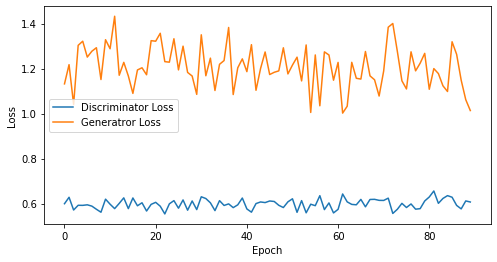

epoch: 90, Discriminator Loss: 0.5982275896602207, Generator Loss: 1.2074756185213724


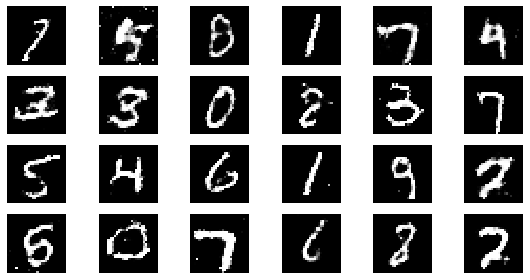

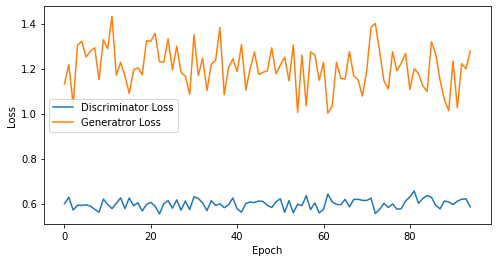

epoch: 95, Discriminator Loss: 0.5986613097943758, Generator Loss: 1.2066561623623497


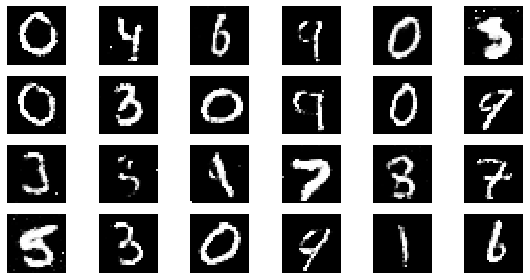

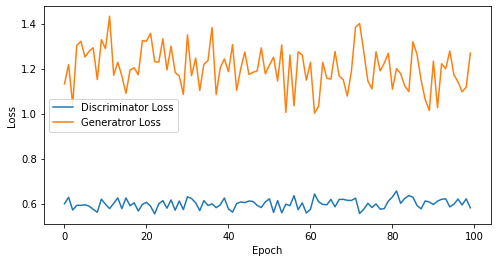

epoch: 100, Discriminator Loss: 0.5988692629337311, Generator Loss: 1.2042953073978424


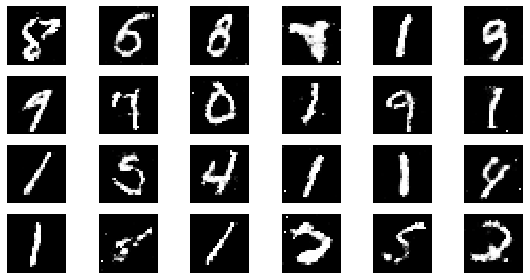

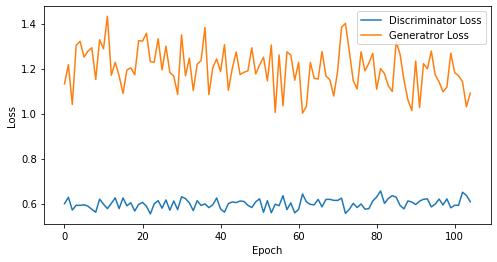

epoch: 105, Discriminator Loss: 0.5996920863787333, Generator Loss: 1.200414310182844


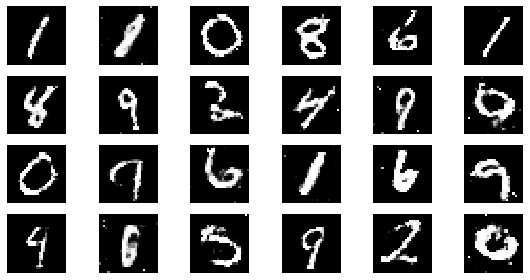

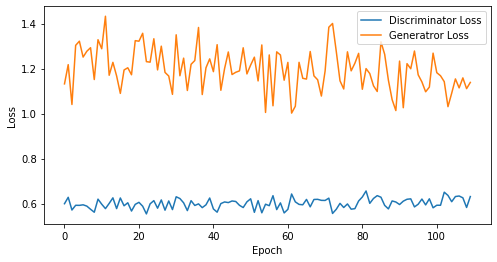

epoch: 110, Discriminator Loss: 0.6006603782827203, Generator Loss: 1.1974624883044849


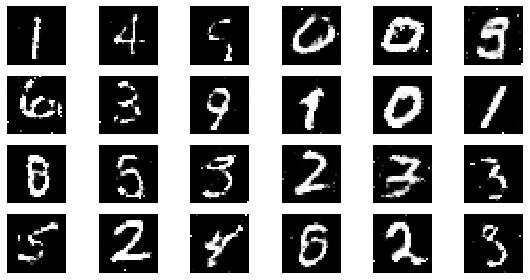

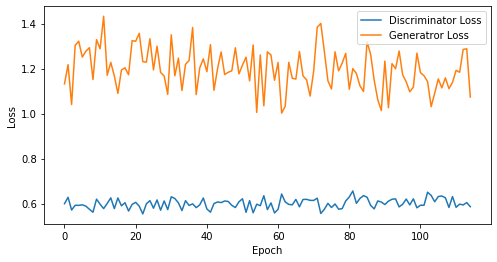

epoch: 115, Discriminator Loss: 0.6003348262413688, Generator Loss: 1.1977796720421832


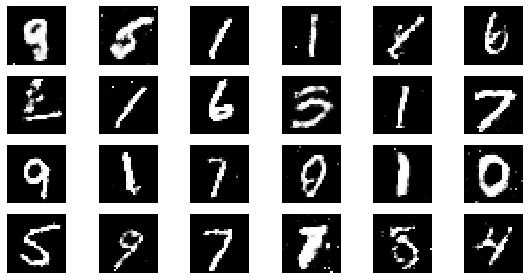

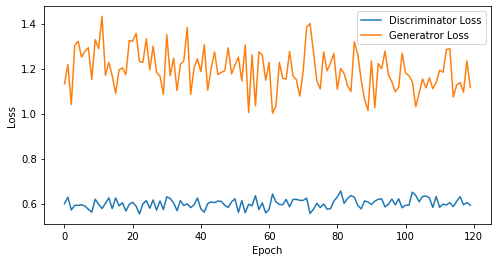

epoch: 120, Discriminator Loss: 0.6005971307555834, Generator Loss: 1.195457966128985


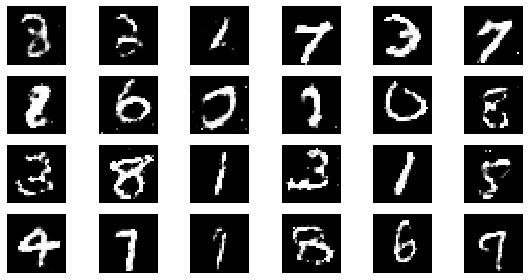

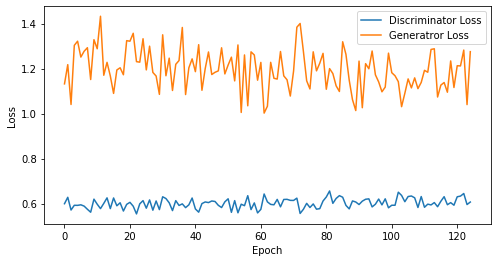

epoch: 125, Discriminator Loss: 0.6014634466171265, Generator Loss: 1.195823854446411


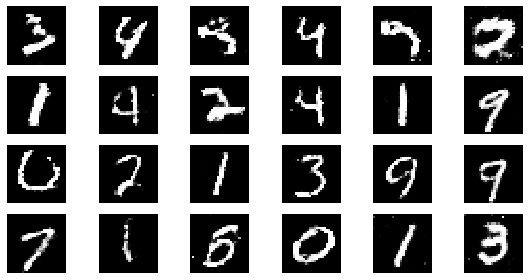

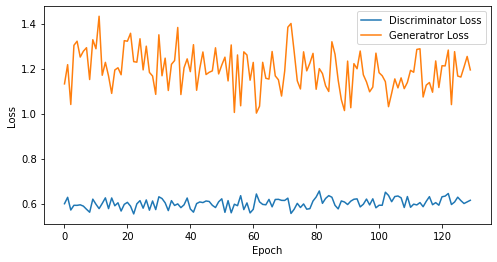

epoch: 130, Discriminator Loss: 0.6019030676438258, Generator Loss: 1.1958707176722012


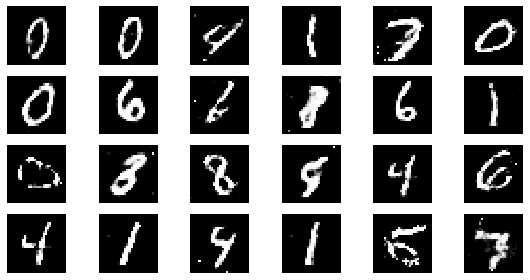

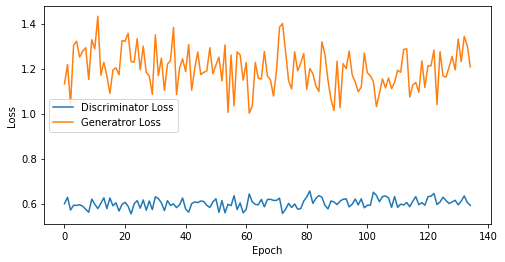

epoch: 135, Discriminator Loss: 0.602101586483143, Generator Loss: 1.1991082527019359


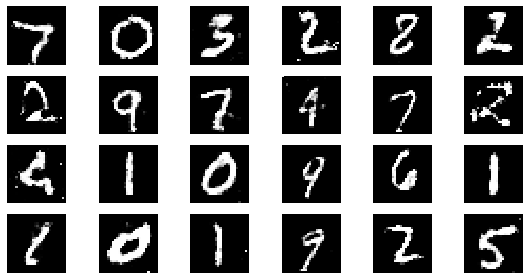

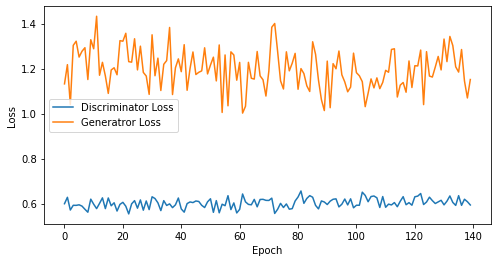

epoch: 140, Discriminator Loss: 0.6023781512464795, Generator Loss: 1.1979700386524201


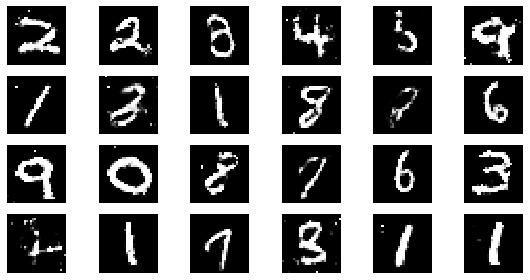

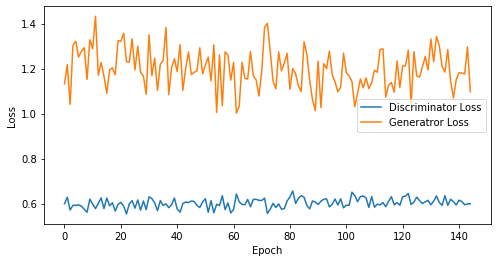

epoch: 145, Discriminator Loss: 0.6024142187217186, Generator Loss: 1.1975739289974343


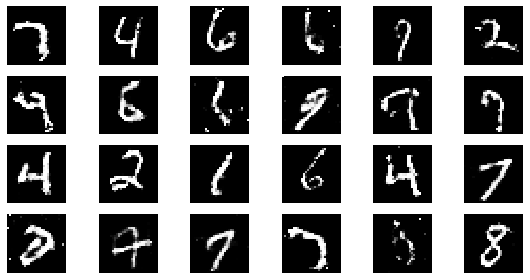

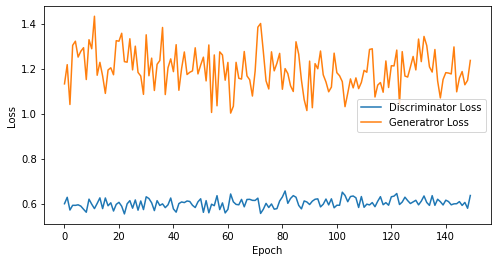

epoch: 150, Discriminator Loss: 0.6024736766020456, Generator Loss: 1.1967066311836243


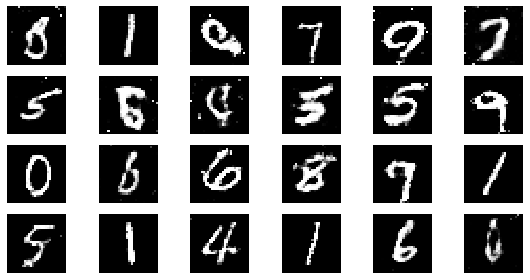

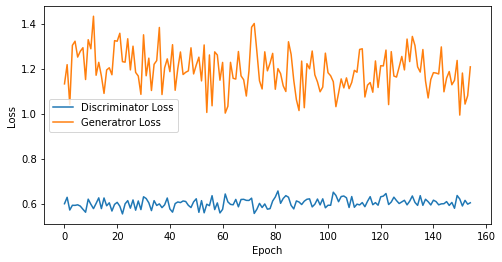

epoch: 155, Discriminator Loss: 0.6025569781180351, Generator Loss: 1.1936120625465148


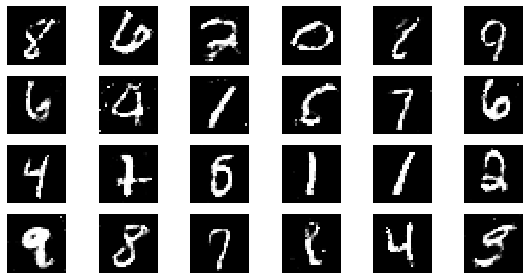

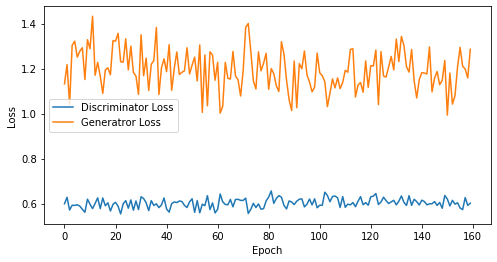

epoch: 160, Discriminator Loss: 0.602316415309906, Generator Loss: 1.1947377875447274


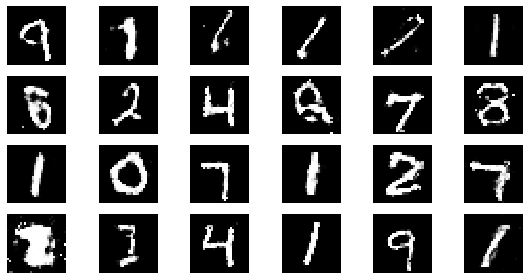

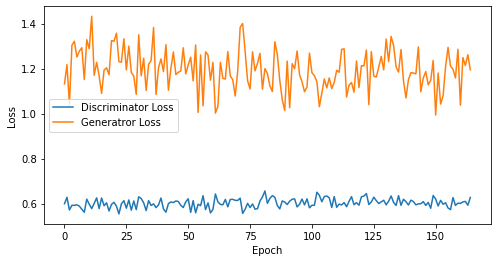

epoch: 165, Discriminator Loss: 0.6024774937918692, Generator Loss: 1.1946386741869377


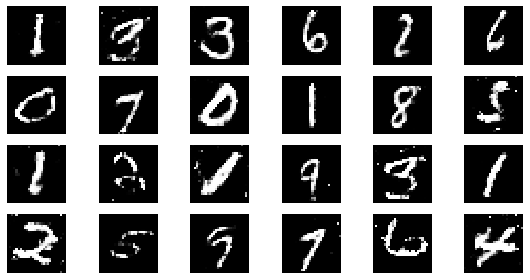

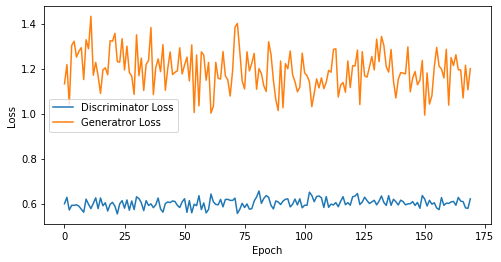

epoch: 170, Discriminator Loss: 0.6024079308790319, Generator Loss: 1.1935257161364836


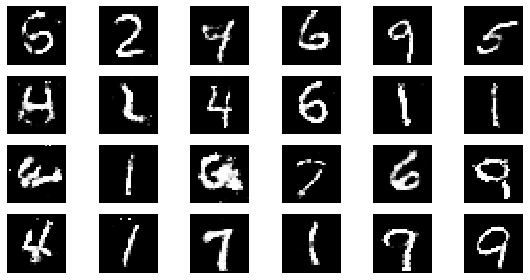

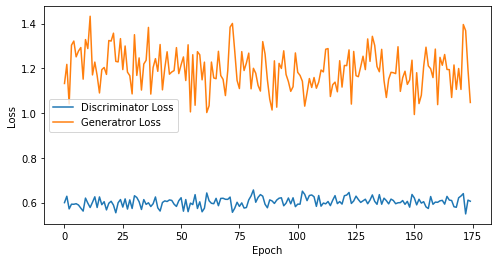

epoch: 175, Discriminator Loss: 0.602534671170371, Generator Loss: 1.1943525968279158


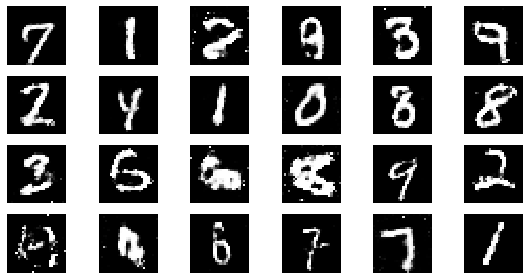

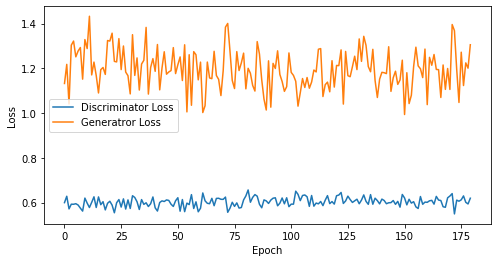

epoch: 180, Discriminator Loss: 0.602770804034339, Generator Loss: 1.1952077547709148


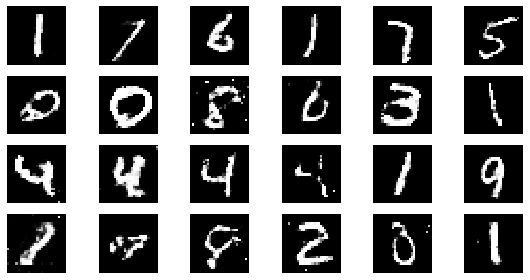

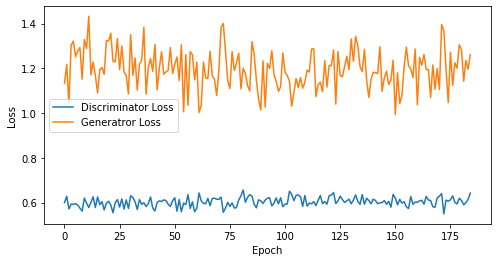

epoch: 185, Discriminator Loss: 0.602991542945037, Generator Loss: 1.195974215945682


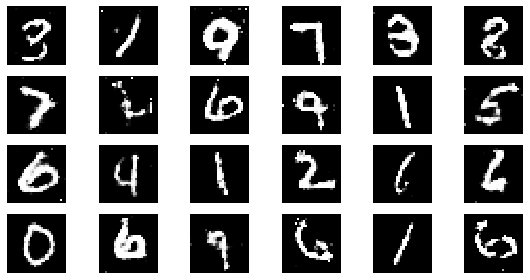

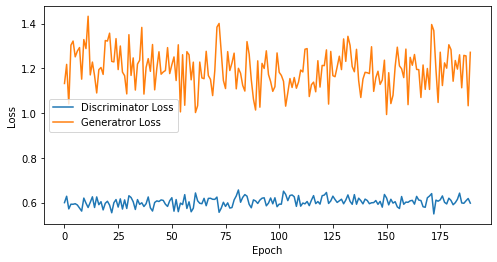

epoch: 190, Discriminator Loss: 0.6030043325926128, Generator Loss: 1.1957153370505884


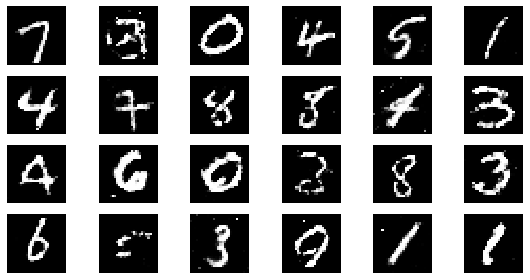

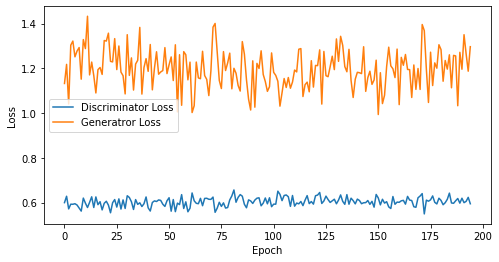

epoch: 195, Discriminator Loss: 0.6031381720151656, Generator Loss: 1.197337226378612


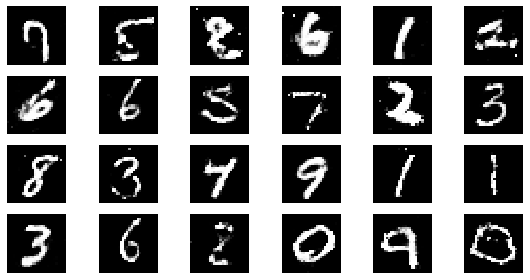

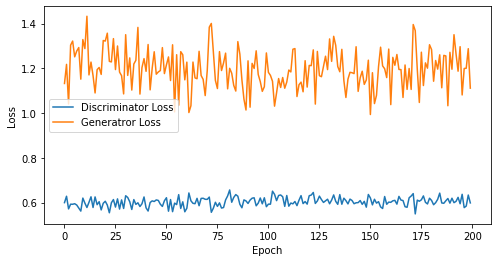

epoch: 200, Discriminator Loss: 0.6032074254751205, Generator Loss: 1.1968027561903


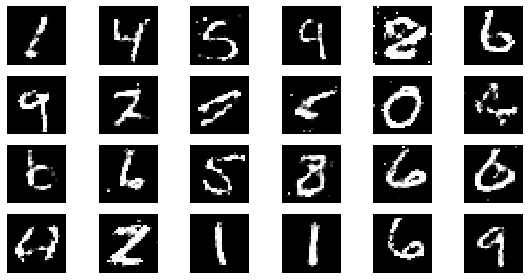

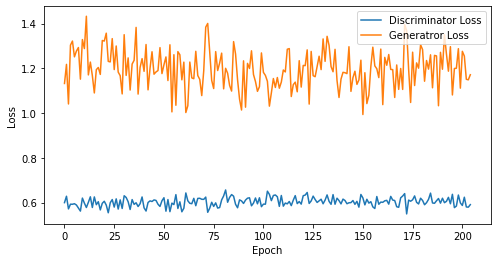

epoch: 205, Discriminator Loss: 0.6029357628124516, Generator Loss: 1.1968888352556926


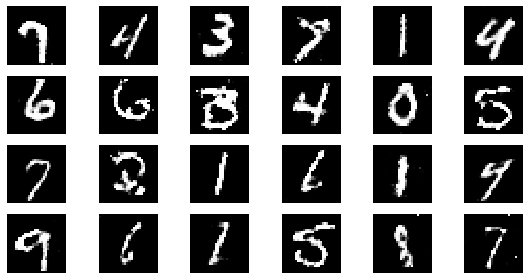

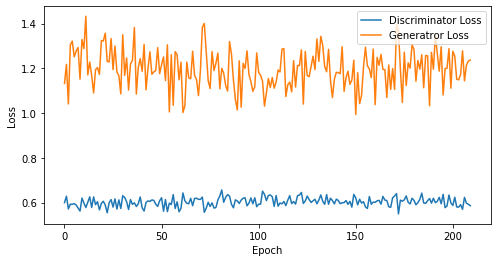

epoch: 210, Discriminator Loss: 0.6027095303648994, Generator Loss: 1.1974678641273862


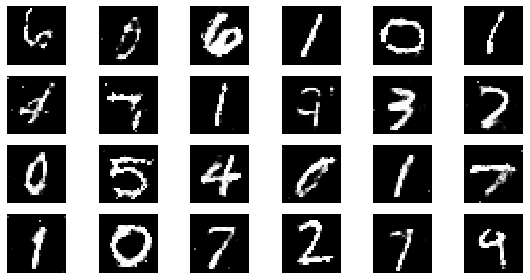

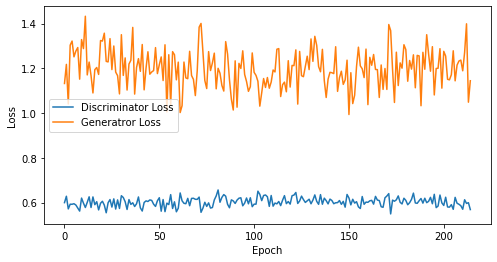

epoch: 215, Discriminator Loss: 0.6023930959923323, Generator Loss: 1.1977701874666435


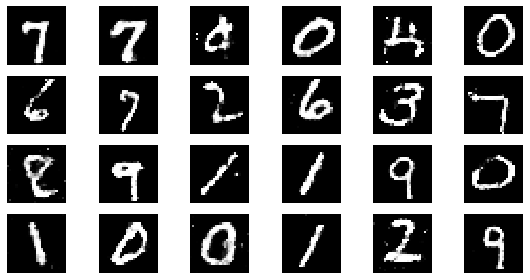

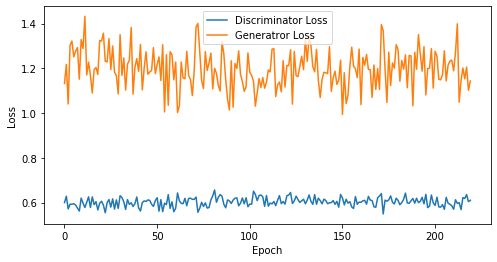

epoch: 220, Discriminator Loss: 0.6027434256943789, Generator Loss: 1.1969362589445982


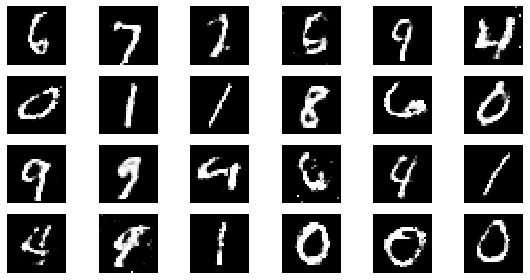

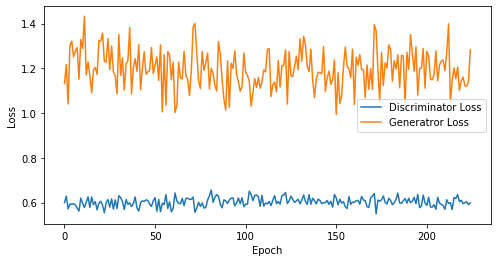

epoch: 225, Discriminator Loss: 0.6026199438836839, Generator Loss: 1.1962328555848862


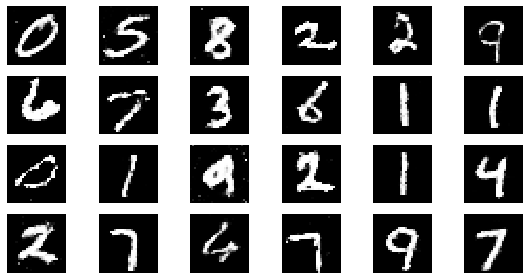

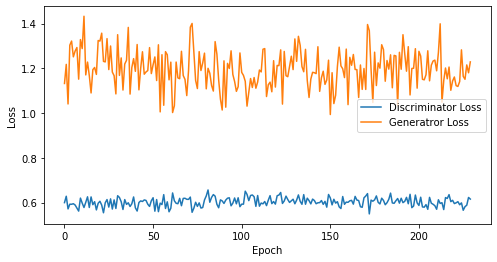

epoch: 230, Discriminator Loss: 0.6024436030698859, Generator Loss: 1.1960520277852598


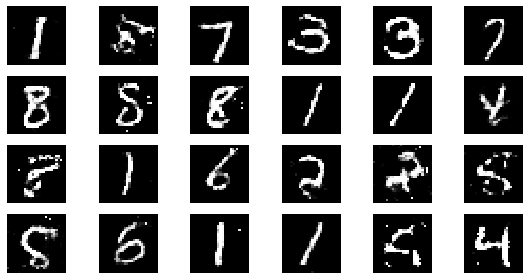

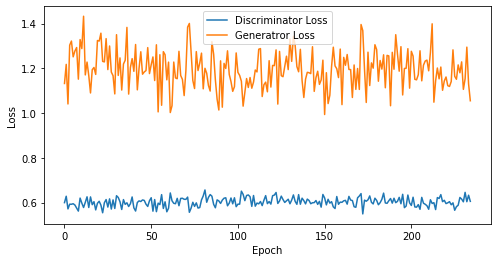

epoch: 235, Discriminator Loss: 0.6027739088586036, Generator Loss: 1.1950260811663689


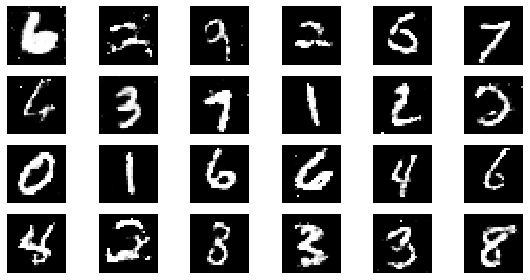

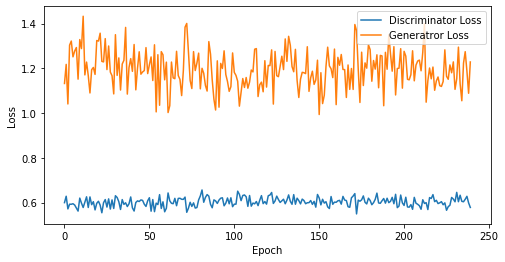

epoch: 240, Discriminator Loss: 0.602807242423296, Generator Loss: 1.1951396644115448


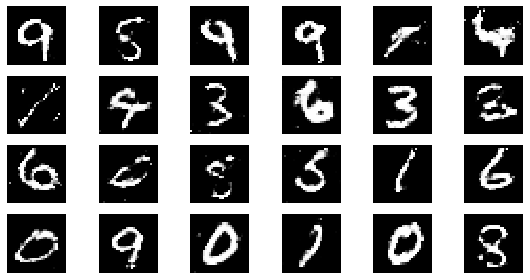

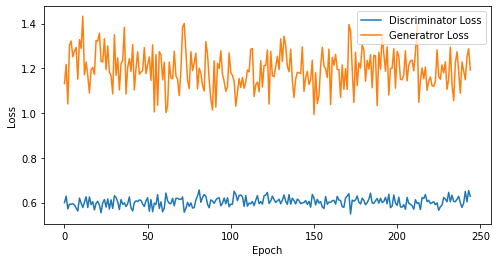

epoch: 245, Discriminator Loss: 0.6032830462163808, Generator Loss: 1.1955129749920903


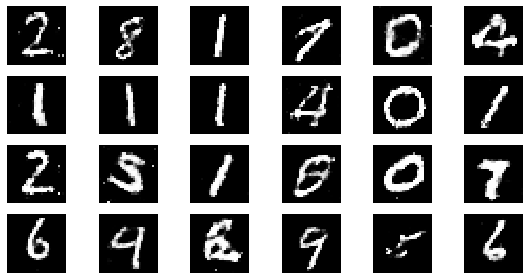

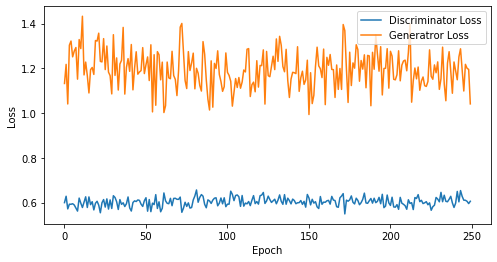

epoch: 250, Discriminator Loss: 0.6033235461711883, Generator Loss: 1.1946135258674622


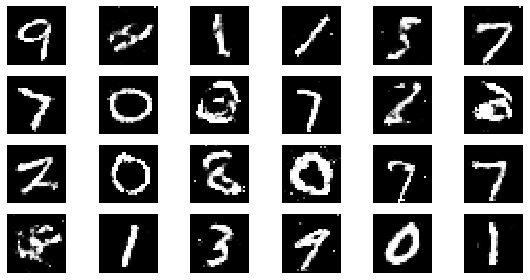

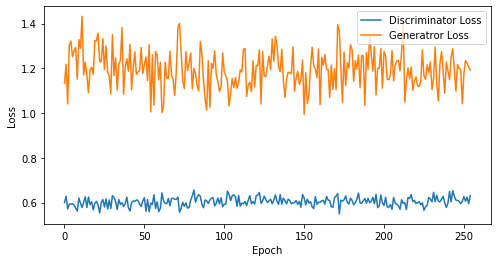

epoch: 255, Discriminator Loss: 0.6035783564343172, Generator Loss: 1.194843908852222


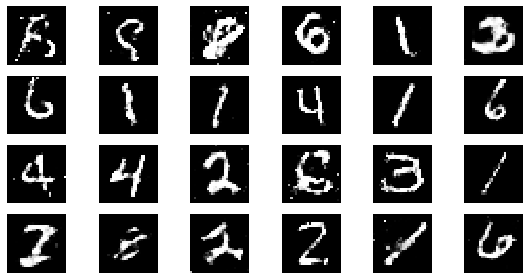

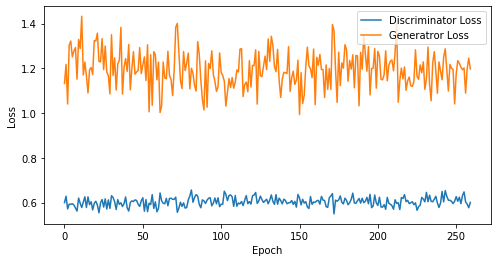

epoch: 260, Discriminator Loss: 0.6035869275148098, Generator Loss: 1.1946847975254058


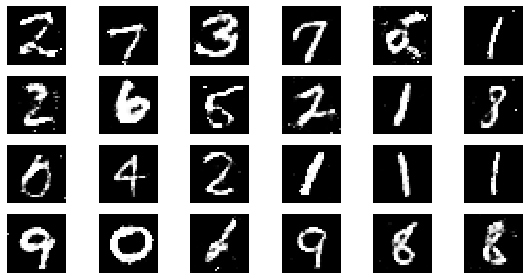

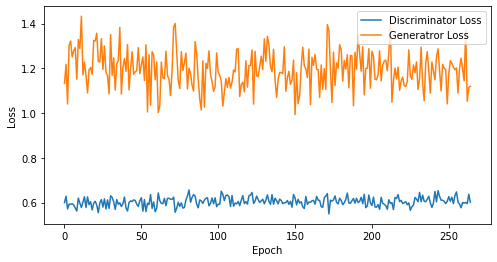

epoch: 265, Discriminator Loss: 0.60363453154294, Generator Loss: 1.1940310325262682


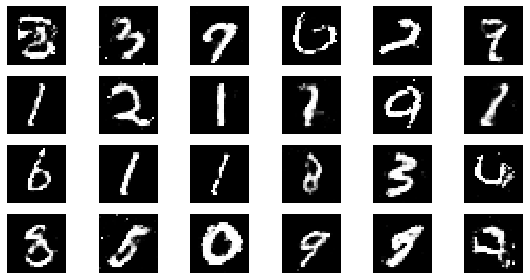

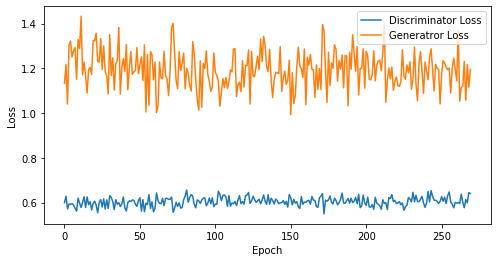

epoch: 270, Discriminator Loss: 0.6038364982163464, Generator Loss: 1.1934597421575475


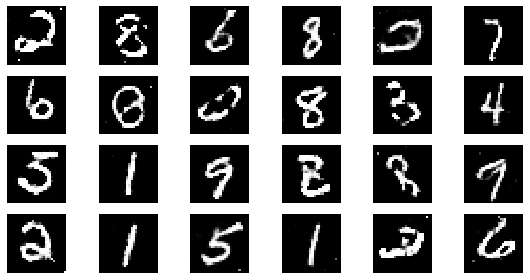

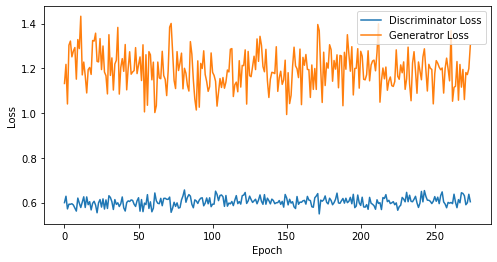

epoch: 275, Discriminator Loss: 0.6039837902242488, Generator Loss: 1.193264699415727


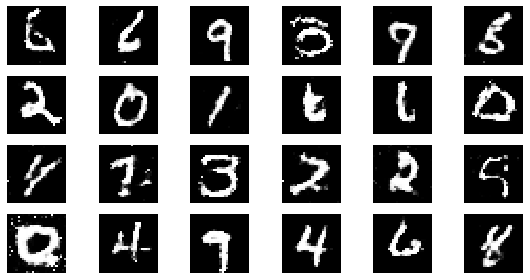

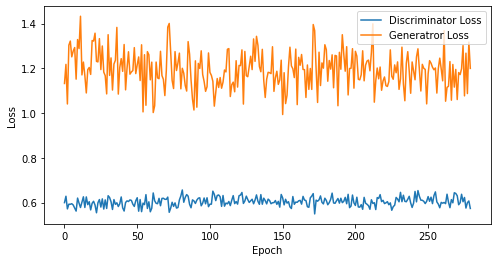

epoch: 280, Discriminator Loss: 0.6038310159529958, Generator Loss: 1.1932028361729212


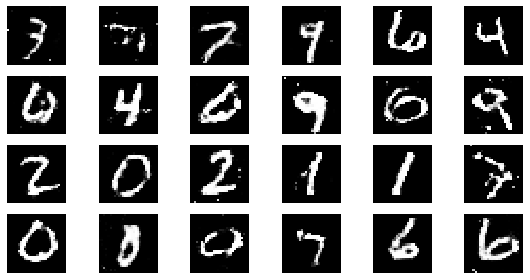

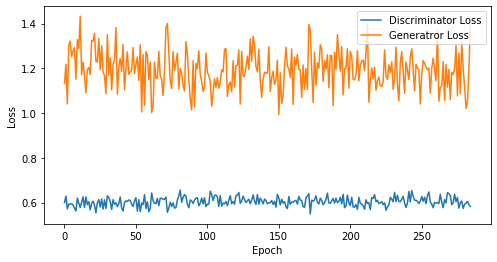

epoch: 285, Discriminator Loss: 0.6036519828595613, Generator Loss: 1.1925087108946684


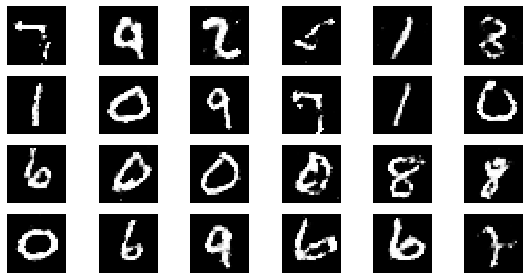

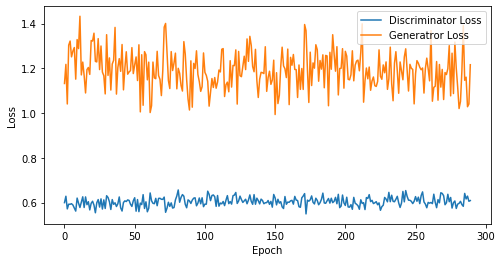

epoch: 290, Discriminator Loss: 0.603931030733832, Generator Loss: 1.1912308532616187


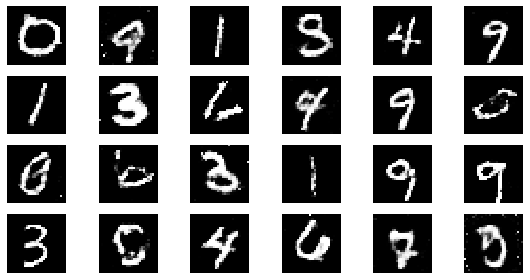

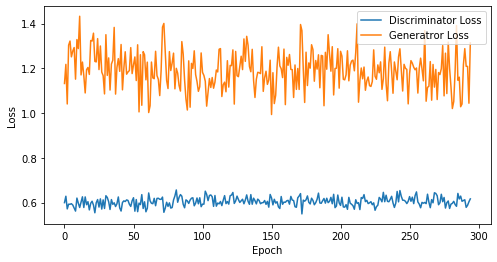

epoch: 295, Discriminator Loss: 0.6038557482978045, Generator Loss: 1.1915957644834356


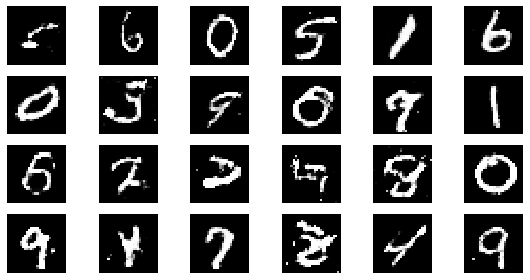

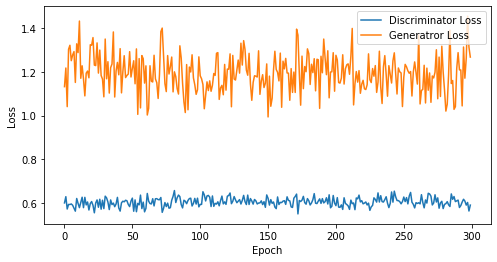

epoch: 300, Discriminator Loss: 0.6036268909772237, Generator Loss: 1.1933002404371897


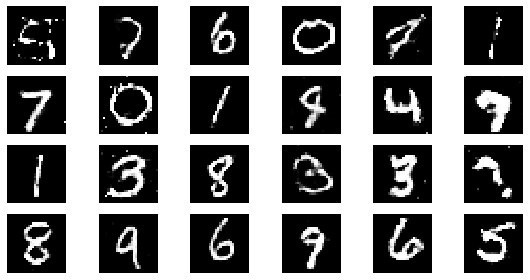

In [25]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)